<a href="https://colab.research.google.com/github/LDankert/ANNs-Tensorflow/blob/main/Homework4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
import time
import pandas as pd
import statistics

**Dataset**

In [ ]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
data = pd.read_csv(url, sep=";")
data = pd.DataFrame(data)
data

In [ ]:
def make_binary(target):
  mean=5.5 #this is not the actual mean, but the midpoint of the quality evaluation
  if target > mean:
    return 1
  else:
    return 0

In [ ]:
validation_dataset=pd.DataFrame.sample(data, frac =0.1) # hier droppen
data.drop(validation_dataset.index) #dropping the validation in order to make sure to not reuse it
train_dataset = pd.DataFrame.sample(data, frac=0.8)
test_dataset = pd.DataFrame.sample(data, frac=0.1)

In [ ]:
#pipeline with make binary and batching

def prepare_data(input_data):
  quality= input_data.pop("quality") #to use as target

  target = quality.map(lambda outcome: make_binary(outcome)) #map the target onto the binary

  feature_names = (input_data.columns.values)
  # extracted feature values
  feature_values = input_data[feature_names]

  dataset = tf.data.Dataset.from_tensors((feature_values, target))
  dataset = dataset.map(lambda input, target: (tf.cast(input, tf.float32), target)) #shape not correct
  #dataset = data_set.map(lambda wine, target: make_binary(tf.float32), target))# here should be the mapping
  dataset = dataset.shuffle(buffer_size=500) #shuffle, batch, prefetch
  dataset = dataset.batch(16)
  dataset = dataset.prefetch(12)
  return dataset

validation_dataset= prepare_data(validation_dataset)
train_dataset= prepare_data(train_dataset)
test_dataset = prepare_data(test_dataset)

validation_dataset

<PrefetchDataset shapes: ((None, 160, 11), (None, 160)), types: (tf.float32, tf.int64)>

**Model**

In [ ]:
class Model(tf.keras.Model):
  
  def __init__(self):
    super().__init__()
    self.hidden_layer_1 = tf.keras.layers.Dense(units=128,
                                          activation=tf.keras.activations.sigmoid)
    self.hidden_layer_2 = tf.keras.layers.Dense(units=128,
                                          activation=tf.keras.activations.sigmoid)
    self.output_layer = tf.keras.layers.Dense(units=1,
                                        activation=tf.keras.activations.sigmoid)
    
  def call(self, inputs):
    x = self.hidden_layer_1(inputs)
    x = self.hidden_layer_2(x)
    x = self.output_layer(x)
    return x

**Training**

In [ ]:
#change in loss function and accuracy
def train_step(model, input, target, loss_function, optimizer):

  with tf.GradientTape() as tape:
    prediction = model(input)
    train_loss = loss_function(target, prediction) #hier noch ändern
    sample_training_accuracy =  np.round(target, 0) == np.round(prediction, 0) #np.round(,0)
    sample_training_accuracy = np.mean(sample_training_accuracy)
    gradients = tape.gradient(train_loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  
  return train_loss , sample_training_accuracy

def test(model, test_data, loss_function):
  # test over complete test data
  test_accuracy_aggregator = []
  test_loss_aggregator = []

  for (input, target) in test_data:
    prediction = model(input)
    sample_test_loss = loss_function(target, prediction) #tf.keras.losses.BinaryCrossentropy()
    sample_test_accuracy =  np.round(target, 0) == np.round(prediction, 0) #np.round(,0)
    sample_test_accuracy = np.mean(sample_test_accuracy)
    test_loss_aggregator.append(sample_test_loss.numpy())
    test_accuracy_aggregator.append(np.mean(sample_test_accuracy))

  test_loss = np.mean(test_loss_aggregator)
  test_accuracy = np.mean(test_accuracy_aggregator)

  return test_loss, test_accuracy

In [ ]:
tf.keras.backend.clear_session()
# validation is needed
# Hyperparameters
num_epochs = 10
learning_rate = 0.1
optimizer = tf.keras.optimizers.SGD(learning_rate=0.1)#momentum
optimizer2 = tf.keras.optimizers.Adam() #adam optimizer
start = time.time()

# Initialize the model.
model = Model()
# Initialize the loss: categorical cross entropy. 
cross_entropy_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
# Initialize the optimizer: SGD with default parameters. 
#optimizer = tf.keras.optimizers.SGD(learning_rate)
#loss_function = tf.keras.losses.BinaryCrossentropy(from_logits=True)
# Initialize lists for later visualization.
train_losses = []
train_accuracies = []

test_losses = []
test_accuracies = []

validation_losses=[]
validation_accuracies=[]

# Testing once before we begin.
test_loss, test_accuracy = test(model, test_dataset, cross_entropy_loss)
test_losses.append(test_loss)
test_accuracies.append(test_accuracy)

# Check how model performs on train data once before we begin.
train_loss, train_accuracy = test(model, train_dataset, cross_entropy_loss)
train_losses.append(train_loss)
train_accuracies.append(train_accuracy)

# We train for num_epochs epochs.
for epoch in range(num_epochs):
    print(f'Epoch: {str(epoch)} starting with accuracy {test_accuracies[-1]}')

    # Training (and checking in with training).
    epoch_loss_agg = []
    epoch_acc_agg = []
    for input, target in train_dataset:
        train_loss, train_accuracy = train_step(model, input, target, cross_entropy_loss, optimizer)
        epoch_loss_agg.append(train_loss)
        epoch_acc_agg.append(train_accuracy)
    #optimizer.apply_gradients(zip(gradients, model.trainable_variables)) 
    # Track training loss and accuracy.
    train_losses.append(tf.reduce_mean(epoch_loss_agg))
    train_accuracies.append(tf.reduce_mean(epoch_acc_agg))

    # Testing
    if epoch % 5==0: #test only twice
      test_loss, test_accuracy = test(model, test_dataset, cross_entropy_loss)
      test_losses.append(test_loss)
      test_accuracies.append(test_accuracy)
    else:
      test_losses.append(0)#to make the plot kinda right
      test_accuracies.append(0)

    #validation
    
   # validation_accuracy_aggregator = []
   # validation_loss_aggregator = []
    #for input, target in validation_dataset:
     # prediction = model(input)
      #sample_validation_loss = cross_entropy_loss(target, prediction) #tf.keras.losses.BinaryCrossentropy()
      #sample_validation_accuracy =  np.round(target, 0) == np.round(prediction, 0) #np.round(,0)
      #sample_validation_accuracy = np.mean(sample_validation_accuracy)
      #validation_loss_aggregator.append(sample_validation_loss.numpy())
      #validation_accuracy_aggregator.append(np.mean(sample_validation_accuracy))

    #validation_loss = np.mean(validation_loss_aggregator)
    #validation_accuracy = np.mean(validation_accuracy_aggregator)

end = time.time()
execution_time = int((end - start)/60)

print(f'Execution time: {execution_time} minutes and {execution_time % 60} seconds.')

#tf.keras.losses.BinaryCrossentropy()

#validation training set needs to be added 
#change the input

Epoch: 0 starting with accuracy 0.48125
Epoch: 1 starting with accuracy 0.48125
Epoch: 2 starting with accuracy 0
Epoch: 3 starting with accuracy 0
Epoch: 4 starting with accuracy 0
Epoch: 5 starting with accuracy 0
Epoch: 6 starting with accuracy 0.48125
Epoch: 7 starting with accuracy 0
Epoch: 8 starting with accuracy 0
Epoch: 9 starting with accuracy 0
Execution time: 0 minutes and 0 seconds.


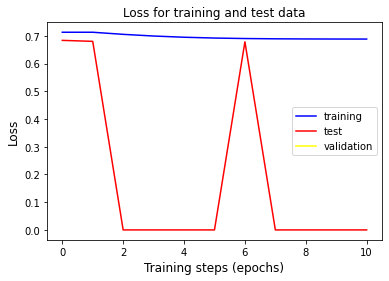

In [ ]:
plt.figure()
line1, = plt.plot(train_losses, color = 'blue')
line2, = plt.plot(test_losses, color = 'red')
line3, = plt.plot(validation_losses, color = 'yellow')
plt.xlabel("Training steps (epochs)", fontsize = 12)
plt.ylabel("Loss", fontsize = 12)
plt.legend((line1, line2, line3),("training", "test", "validation"))
plt.title('Loss for training and test data')
plt.show()

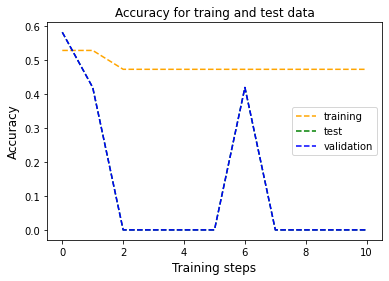

In [ ]:
plt.figure()
line1, = plt.plot(train_accuracies, linestyle = 'dashed', color = 'orange')
line2, = plt.plot(test_accuracies, linestyle = 'dashed', color = 'green')
line3, = plt.plot(test_accuracies, linestyle = 'dashed', color = 'blue')
plt.xlabel("Training steps", fontsize = 12)
plt.ylabel("Accuracy", fontsize = 12)
plt.legend((line1, line2, line3),("training", "test", "validation"))
plt.title('Accuracy for traing and test data')
plt.show()

Training with a different Optimizer and mini **batch** and early stopping

In [ ]:
validation_dataset=pd.DataFrame.sample(data, frac =0.1) # hier droppen
data.drop(validation_dataset.index)
train_dataset = pd.DataFrame.sample(data, frac=0.8)
train_dataset
test_dataset = pd.DataFrame.sample(data, frac=0.1)

In [ ]:

def prepare_data(input_data):
  quality= input_data.pop("quality") #quality to use for target
  #target=[]
  target = quality.map(lambda outcome: make_binary(outcome)) #mapping the target

  feature_names = (input_data.columns.values) #prepare data for tf
  # extracted feature values
  feature_values = input_data[feature_names]
  #input_data['Address'] = target
  # creating the tensorflow dataset
  dataset = tf.data.Dataset.from_tensors((feature_values, target))
  dataset = dataset.map(lambda input, target: (tf.cast(input, tf.float32), target)) #shape not correct
  #dataset = data_set.map(lambda wine, target: make_binary(tf.float32), target))# here should be the mapping
  # no batching etc
  return dataset

validation_dataset= prepare_data(validation_dataset)
train_dataset= prepare_data(train_dataset)
test_dataset = prepare_data(test_dataset)
validation_dataset

<MapDataset shapes: ((160, 11), (160,)), types: (tf.float32, tf.int64)>

In [ ]:
#change in loss function and accuracy
def train_step(model, input, target, loss_function, optimizer):

  with tf.GradientTape() as tape:
    prediction = model(input)
    train_loss = loss_function(target, prediction) #hier noch ändern
    sample_training_accuracy =  np.round(target, 0) == np.round(prediction, 0) #np.round(,0)
    sample_training_accuracy = np.mean(sample_training_accuracy)
    gradients = tape.gradient(train_loss, model.trainable_variables)
  optimizer2.apply_gradients(zip(gradients, model.trainable_variables))
  
  return train_loss , sample_training_accuracy

def test(model, test_data, loss_function):
  # test over complete test data
  test_accuracy_aggregator = []
  test_loss_aggregator = []

  for (input, target) in test_data:
    prediction = model(input)
    sample_test_loss = loss_function(target, prediction) #tf.keras.losses.BinaryCrossentropy()
    sample_test_accuracy =  np.round(target, 0) == np.round(prediction, 0) #np.round(,0)
    sample_test_accuracy = np.mean(sample_test_accuracy)
    test_loss_aggregator.append(sample_test_loss.numpy())
    test_accuracy_aggregator.append(np.mean(sample_test_accuracy))

  test_loss = np.mean(test_loss_aggregator)
  test_accuracy = np.mean(test_accuracy_aggregator)

  return test_loss, test_accuracy

In [ ]:
tf.keras.backend.clear_session()
# validation is needed
# Hyperparameters
num_epochs = 10
learning_rate = 0.1
optimizer = tf.keras.optimizers.SGD(learning_rate=1)#momentum
optimizer2 = tf.keras.optimizers.Adam(learning_rate=0.1) #adam optimizer
start = time.time()

# Initialize the model.
model = Model()
# Initialize the loss: categorical cross entropy. 
cross_entropy_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
# Initialize the optimizer: SGD with default parameters. 
optimizer = tf.keras.optimizers.SGD(learning_rate)
#loss_function = tf.keras.losses.BinaryCrossentropy(from_logits=True)
# Initialize lists for later visualization.
train_losses = []
train_accuracies = []

test_losses = []
test_accuracies = []

validation_losses=[]
validation_accuracies=[]
# Testing once before we begin.
test_loss, test_accuracy = test(model, test_dataset.take(320).batch(32), cross_entropy_loss)
test_losses.append(test_loss)
test_accuracies.append(test_accuracy)

# Check how model performs on train data once before we begin.
train_loss, train_accuracy = test(model, train_dataset.take(320).batch(32), cross_entropy_loss)
train_losses.append(train_loss)
train_accuracies.append(train_accuracy)

# We train for num_epochs epochs.
for epoch in range(num_epochs):
    print(f'Epoch: {str(epoch)} starting with accuracy {test_accuracies[-1]}')

    # Training (and checking in with training).
    epoch_loss_agg = []
    epoch_acc_agg = []
    for input, target in train_dataset:
        train_loss_old = train_loss
        train_loss, train_accuracy = train_step(model, input, target, cross_entropy_loss, optimizer2)
        epoch_loss_agg.append(train_loss)
        epoch_acc_agg.append(train_accuracy)
    #optimizer.apply_gradients(zip(gradients, model.trainable_variables)) 
    # Track training loss and accuracy.
    train_losses.append(tf.reduce_mean(epoch_loss_agg))
    train_accuracies.append(tf.reduce_mean(epoch_acc_agg))

    if epoch % 5==0:
      test_loss, test_accuracy = test(model, test_dataset, cross_entropy_loss)
      test_losses.append(test_loss)
      test_accuracies.append(test_accuracy)
    else:
      test_losses.append(0)#to make the plot kinda right
      test_accuracies.append(0)

    #validation
    validation_accuracy_aggregator = []
    validation_loss_aggregator = []
    for input, target in validation_dataset:
      prediction = model(input)
      sample_validation_loss = cross_entropy_loss(target, prediction) #tf.keras.losses.BinaryCrossentropy()
      sample_validation_accuracy =  np.round(target, 0) == np.round(prediction, 0) #np.round(,0)
      sample_validation_accuracy = np.mean(sample_validation_accuracy)
      validation_loss_aggregator.append(sample_validation_loss.numpy())
      validation_accuracy_aggregator.append(np.mean(sample_validation_accuracy))
    validation_old= validation_loss
    validation_loss = np.mean(validation_loss_aggregator)
    validation_accuracy = np.mean(validation_accuracy_aggregator)
     

    if validation_loss > validation_old and train_loss < train_loss_old:
      break

end = time.time()
execution_time = int((end - start)/60)

print(f'Execution time: {execution_time} minutes and {execution_time % 60} seconds.')

#tf.keras.losses.BinaryCrossentropy()

#validation training set needs to be added 
#change the input

Epoch: 0 starting with accuracy 0.41875
Epoch: 1 starting with accuracy 0.41875
Execution time: 0 minutes and 0 seconds.


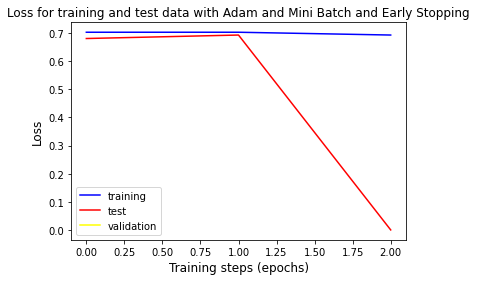

In [ ]:
plt.figure()
line1, = plt.plot(train_losses, color = 'blue')
line2, = plt.plot(test_losses, color = 'red')
line3, = plt.plot(validation_losses, color = 'yellow')
plt.xlabel("Training steps (epochs)", fontsize = 12)
plt.ylabel("Loss", fontsize = 12)
plt.legend((line1, line2, line3),("training", "test", "validation"))
plt.title('Loss for training and test data with Adam and Mini Batch and Early Stopping')
plt.show()

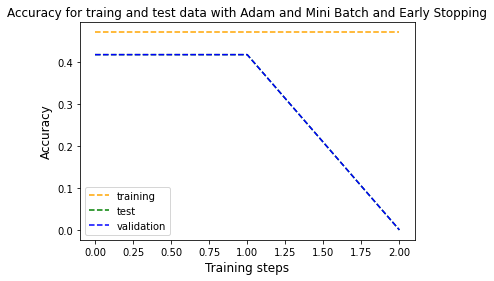

In [ ]:
plt.figure()
line1, = plt.plot(train_accuracies, linestyle = 'dashed', color = 'orange')
line2, = plt.plot(test_accuracies, linestyle = 'dashed', color = 'green')
line3, = plt.plot(test_accuracies, linestyle = 'dashed', color = 'blue')
plt.xlabel("Training steps", fontsize = 12)
plt.ylabel("Accuracy", fontsize = 12)
plt.legend((line1, line2, line3),("training", "test", "validation"))
plt.title('Accuracy for traing and test data with Adam and Mini Batch and Early Stopping')
plt.show()